<img src="./resources/images/banner2.png" width="100%" alt="Encabezado MLDS">

# **Entendimiento y Preparación del Corpus**
---
## **0. Integrantes del equipo de trabajo**
---

<table><thead>
  <tr>
    <th>#</th>
    <th>Integrante</th>
    <th>Documento de identidad</th>
  </tr></thead>
<tbody>
  <tr>
    <td>1</td>
    <td>Ivonne Cristina Ruiz Páez</td>
    <td>1014302058</td>  
  </tr>
  <tr>
    <td>2</td>
    <td>Diego Alejandro Feliciano Ramos</td>
    <td>1024586904</td>
  </tr>
  <tr>
    <td>3</td>
    <td>Cristhian Enrique Córdoba Trillos</td>
    <td>1030649666</td>
  </tr>
</tbody>
</table>

## **1. Análisis Exploratorio de los Textos**
---

### **1.1. Resumen General de los Textos**

________________

- ¿Cuál es la fuente origen de los datos?
  * Recopilación de publicaciones redes sociales (X, reddit, algunos chatbots). Estas publicaciones fueron recolectadas específicamente para realizar un análisis de sentimientos relacionado con la salud mental.

- ¿Cuántos documentos tiene el corpus?
  * El corpus tiene 53.043 docuemntos. En nuestro dataset cada documento corresponde a un mensaje o "tweet" publicado. Así, cada registro es un tweet, donde la estructura del dataset inicial tiene con 2 columnas: la primera contiene el mensaje, y la segunda una etiqueta dentro de las siguientes categorías: 1) Ansiedad, 2) Bipolaridad, 3) Depresión, 4) Normal, 5) Desorden de personalidad, 6) Estrés, y 7) Tendencia suicida.

- ¿En qué idioma se encuentran?
  * Los documentos del corpus son una recopilación de posts en distintas redes sociales en idioma inglés.

- ¿Qué tamaño en MB tiene el corpus?
  *  El corpus tiene un peso aproximado de 31.5 MB

- ¿Hay alguna relación entre distintos documentos del corpus?
  * Los documentos del corpus están relacionados en sentido de que todos son publicaciones individuales o conversaciones de los usuarios de las redes sociales. Estas publicaciones fueron recopiladas para el análisis de sentimientos, por tanto, no existe una relación explícita entre los docuemntos más allá de este contexto común.


### **1.2. Resumen de la Calidad de los Textos**
______________

- ¿Hay datos faltantes o documentos vacíos?
  * Hay 0 valores faltantes en la columna "status" mientras hay 362 valores faltantes en al columna "statement". Los 362 valores faltantes en la columna "statement" corresponden al 0.63% del total de registros, así, la proporción de nulos es muy baja. En conclusión, la completitud del dataset es del 99.3 %, apróximadamente.

- ¿Existen documentos ilegibles o con problemas de codificación?
  * Posterior a eliminar valores duplicados, valores nulos y columnas con únicamente valores númericos, no se evidencian problemas de ilegibilidad o codificación.

- ¿Hay mezcla de idiomas en el corpus?, ¿qué se puede hacer al respecto?
  * El corpus está construido principalmente en idioma inglés, por tanto, hay una mezcla de idiomas en el mismo, esta mezcla incluye portugués, neerlandés y algunas entradas ilegibles.

In [58]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import string
import nltk
import seaborn as sns
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import plotly.figure_factory as ff
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
# Descargar última versión
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")
print("Path to dataset files:", path)

Path to dataset files: /kaggle/input/sentiment-analysis-for-mental-health


In [ ]:
##Cargamos nuestra base de datos
path = '/kaggle/input/sentiment-analysis-for-mental-health/Combined Data.csv'
df_bruto = pd.read_csv(path)

In [ ]:
df_bruto=df_bruto.iloc[:,1:]
pd.concat([df_bruto.head(4), df_bruto.tail(4)])

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety
53042,I have really bad door anxiety! It's not about...,Anxiety


In [27]:
df_bruto.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     53043 non-null  object
dtypes: object(2)
memory usage: 828.9+ KB


La siguiente función devuelve un pequeño DataFrame con: nulos y duplicados (conteo + %), filas de statement solo numéricas y la completitud global del dataset.

In [49]:
def resumen(dataset):
    nulls = dataset.isnull().sum()
    nulls_per = (dataset.isnull().sum()) / len(dataset)
    duplicated_values = dataset.duplicated().sum()
    duplicated_values_per = (dataset.duplicated().sum()) / len(dataset)
    solo_numeros = dataset[dataset['statement'].str.match(r'^\d+(\s\d+)*$', na=False)]
    total_records = len(dataset)
    total_nulls = df_bruto.isnull().sum().sum()
    completitud = (total_records * len(df_bruto.columns) - total_nulls) / (total_records * len(df_bruto.columns))
    info_frame = pd.DataFrame({'Valores_Nulos' : nulls ,
                              'Valores_Nulos %' :nulls_per,
                              'Valores_Duplicados' :duplicated_values,
                              'Valores_Duplicados %':duplicated_values_per,
                              'Filas_Solo_Numeros:': len(solo_numeros),
                               'Completitud_Dataset': completitud})
    return info_frame.T

In [52]:
resumen(df_bruto)

,statement,status
Valores_Nulos,362.000000,0.000000
Valores_Nulos %,0.006825,0.000000
Valores_Duplicados,1944.000000,1944.000000
Valores_Duplicados %,0.036650,0.036650
Filas_Solo_Numeros:,1.000000,1.000000
Completitud_Dataset,0.996588,0.996588


In [104]:
# Eliminar datos duplicados en el dataset
df_preclean = df_bruto.drop_duplicates()
# Eliminar valores nulos
df_preclean = df_preclean.dropna()
# Eliminar filas con números en el dataset
df_preclean = df_preclean[~df_preclean['statement'].str.contains(r'\d', na=False)]

In [55]:
resumen(df_preclean)

,statement,status
Valores_Nulos,0.000000,0.000000
Valores_Nulos %,0.000000,0.000000
Valores_Duplicados,0.000000,0.000000
Valores_Duplicados %,0.000000,0.000000
Filas_Solo_Numeros:,0.000000,0.000000
Completitud_Dataset,0.994805,0.994805


In [56]:
def check_encoding_issues(df, column):
    encoding_issues = []
    for index, value in df[column].items():
        try:
            value.encode('utf-8')
        except UnicodeEncodeError:
            encoding_issues.append(index)
    return encoding_issues

# Verificamos problemas de codificación en las columnas 'statement' y 'status'
encoding_issues_statement = check_encoding_issues(df_preclean, 'statement')
encoding_issues_status = check_encoding_issues(df_preclean, 'status')
print()
print(f"Documentos ilegibles o con problemas de codificación en la columna 'statement': {encoding_issues_statement}")
print(f"Documentos ilegibles o con problemas de codificación en la columna 'status': {encoding_issues_status}")

Documentos ilegibles o con problemas de codificación en la columna 'statement': []
Documentos ilegibles o con problemas de codificación en la columna 'status': []


### **1.3. Tipos de variables**
---

- ¿El corpus tiene una variable objetivo a estimar?, de ser así, ¿es una variable continúa o categórica?
- Analice la distribución de las etiquetas, identifique si hay desbalanceo de datos.
- Analice los documentos, y determine cuál es la distribución de la longitud de los documentos a nivel carácter o palabra.
- ¿El conjunto de datos cuenta con otras variables adicionales?, de ser así, debe analizar cuáles se incorporarán en el modelo y hacer un análisis descriptivo de las mismas.

____________

- ¿El corpus tiene una variable objetivo a estimar?, de ser así, ¿es una variable continúa o categórica?

  * Sí, el corpus tiene una variable objetivo a estimar, que es la columna 'status'. Esta variable es de tipo categórico, la cual contiene alguno de los siguientes categorías respecto de la salud mental: 1) Ansiedad, 2) Bipolaridad, 3) Depresión, 4) Normal, 5) Desorden de personalidad, 6) Estrés, y 7) Tendencia suicida.

- Analice la distribución de las etiquetas, identifique si hay desbalanceo de datos.

  * Considerando que una categoría del dataset presenta desbalanceo si tienen una proporción lo sufiientemente pequeña respecto de las demás en el dataset. En este caso, si consideramos que una categoría tiene menos del 10% del total la consideramos como una categoría desbalanceada.
      
    Así, identificamos desbalanceo en la distribución de los datos. En este caso, las categorías con desbalanceo notable son: Ansiedad, Estrés, Bipolaridad, y Desorden de personalidad.

    Las cuatro categorías mencionadas tienen una proporción de 5.8%, 8.7%, 2.9%, y 1.45%, respectivamente.

- Analice los documentos, y determine cuál es la distribución de la longitud de los documentos a nivel carácter o palabra.

  * Distribución de la Longitud de los Documentos a Nivel Carácter:
    
    La mayoría de los documentos tienen una longitud que varía entre 50 y 150 caracteres. Esto indica que los documentos suelen ser relativamente cortos, lo cual es típico en publicaciones de redes sociales como tweets.

  * Distribución de la Longitud de los Documentos a Nivel Palabra:

    La mayoría de los documentos tienen una longitud que varía entre 10 y 30 palabras. Esto sugiere que los documentos contienen mensajes concisos, lo cual es consistente con el formato de publicaciones en redes sociales.

  * Conclusión: La longitud de los documentos en el dataset está distribuida de manera que la mayoría de los documentos tienen entre 50 y 150 caracteres y entre 10 y 30 palabras. Esta conclusión es consecuente dado que los tweets están limitados a 280 carácteres.

    Este análisis proporciona una visión clara de la longitud típica de los documentos en el dataset, lo cual es crucial para diseñar estrategias de preprocesamiento y modelado adecuadas.

- ¿El conjunto de datos cuenta con otras variables adicionales?, de ser así, debe analizar cuáles se incorporarán en el modelo y hacer un análisis descriptivo de las mismas.

  * No, el dataset no cuenta con variables adicionales.


In [76]:
def distribucion(df):
    # Contar los casos para cada status
    status_counts = df['status'].value_counts()

    # Calcular la proporción sobre el total
    total_count = len(df)
    status_proportion = (status_counts / total_count) * 100

    # Crear un DataFrame con los resultados
    distribution_df = pd.DataFrame({
        'status': status_counts.index,
        'Conteo': status_counts.values,
        'Proporción': status_proportion.values
    })
    return distribution_df

In [77]:
distribucion(df_preclean)

,status,Conteo,Proporción
0,Normal,13968,40.089547
1,Depression,9344,26.818208
2,Suicidal,6679,19.169393
3,Anxiety,1930,5.539292
4,Stress,1341,3.848803
5,Bipolar,1062,3.048045
6,Personality disorder,518,1.486711


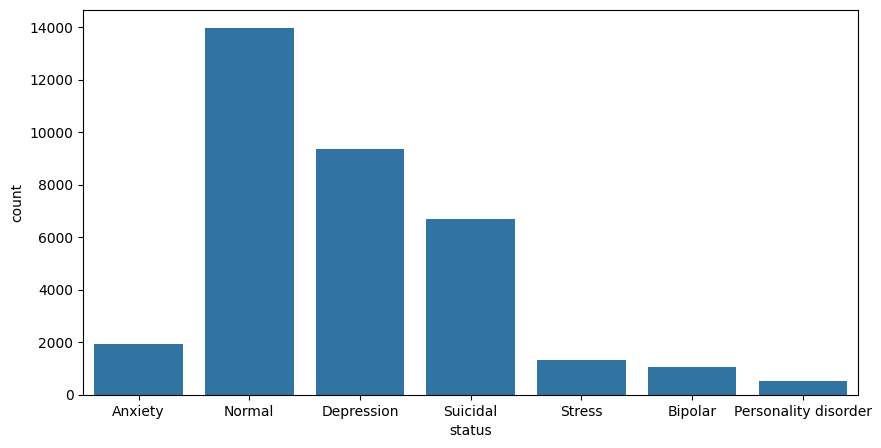

In [66]:
plt.figure(figsize=(10,5))
sns.countplot(data=df_preclean,x='status')
plt.show()

In [105]:
df_preclean['char_length'] = df_preclean['statement'].apply(len)
df_preclean['word_length'] = df_preclean['statement'].apply(lambda x: len(x.split()))
# Distribuciones.
print("Distribución de la longitud de los documentos a nivel carácter:")
print("/---------------------------------------/")
print(df_preclean['char_length'].describe())
print("/---------------------------------------/")
print("Distribución de la longitud de los documentos a nivel palabra:")
print("/---------------------------------------/")
print(df_preclean['word_length'].describe())

Distribución de la longitud de los documentos a nivel carácter:
/---------------------------------------/
count    34842.000000
mean       345.402015
std        515.991809
min          2.000000
25%         53.000000
50%        164.000000
75%        461.000000
max      32759.000000
Name: char_length, dtype: float64
/---------------------------------------/
Distribución de la longitud de los documentos a nivel palabra:
/---------------------------------------/
count    34842.000000
mean        67.970495
std         98.042080
min          1.000000
25%         10.000000
50%         32.000000
75%         91.000000
max       6300.000000
Name: word_length, dtype: float64


<Figure size 1000x500 with 0 Axes>

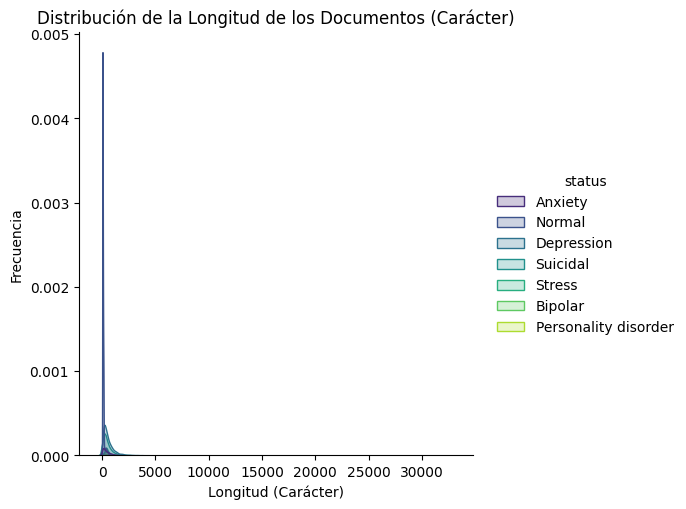

In [106]:
# Distribución a nivel carácter
plt.figure(figsize=(10, 5))
sns.displot(data=df_preclean, x='char_length', hue='status', kind='kde', fill=True, palette='viridis')
plt.title('Distribución de la Longitud de los Documentos (Carácter)')
plt.xlabel('Longitud (Carácter)')
plt.ylabel('Frecuencia')
plt.show()

<Figure size 1000x500 with 0 Axes>

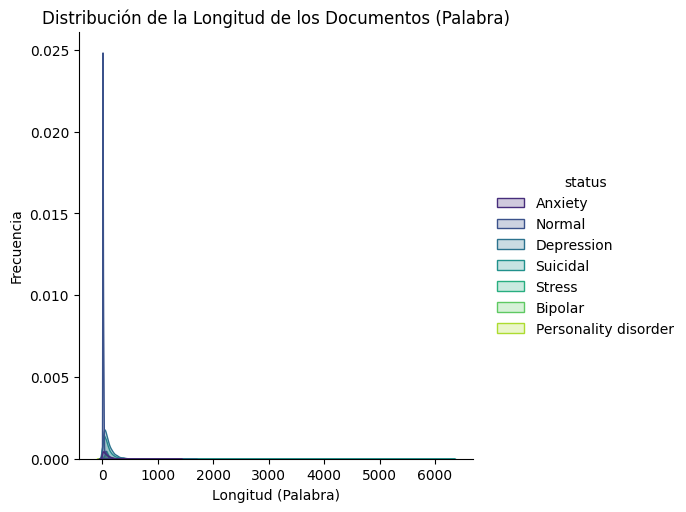

In [107]:
# Distribución a nivel palabra
plt.figure(figsize=(10, 5))
sns.displot(data=df_preclean, x='word_length', hue='status', kind='kde', fill=True, palette='viridis')
plt.title('Distribución de la Longitud de los Documentos (Palabra)')
plt.xlabel('Longitud (Palabra)')
plt.ylabel('Frecuencia')
plt.show()

### **1.4. Relación Entre Variables**
---

- Analice si existe alguna relación entre las variables. Puede utilizar medidas de correlación o visualizaciones.
- Identifique si hay redundancia entre las variables para una posterior eliminación o selección.

________

- Analice si existe alguna relación entre las variables. Puede utilizar medidas de correlación o visualizaciones.

  * char_length y word_length:
  
    La corrrelación entre char_length (longitud letras) y word_lenght (longitud palabras) es muy alta (0.96), lo cual es lógico pues ambas variables son construidas a partir de la misma variable base ('statement'). Adicionalmente, la relación entre ambas variables es casi lineal, como lo muestra la gráfica de scatterplot realizada.

  * 'status' y las longitudes de letras o palabras ('status' y 'word/char_length'):

    *  **Correlación Baja entre char_length o word_length respecto de status**: La matriz de correlación muestra una baja correlación entre la longitud de los documentos (char_length y word_length) y todos los estados de status. Los coeficientes de correlación van desde 0.036 hasta 0.091, lo que sugiere que no hay una relación fuerte entre la longitud del carácter y cualquier estado específico.

    * **Relaciones Específicas dentro de status**: Algunas relaciones dentro de las variables status muestran mayores niveles de correlación, como por ejemplo, entre status_Depression y char/word_length (0.26). Esto indica que estos dos estados tienden a ocurrir juntos más frecuentemente, lo cual puede ser relevante para el análisis de co-ocurrencia de estados emocionales.

    * **Correlaciones Negativas**: Existen algunas relaciones negativas significativas, como entre status_Normal y otros estados como status_Depression (-0.51) o status_Suicidal (-0.29). Esto sugiere que estar en un estado normal está inversamente relacionado con estar en un estado depresivo o suicida, lo cual es consistente con la naturaleza opuesta de estos estados emocionales.

    * **Impacto del Estado Emocional en la Longitud del Texto**: La falta de correlación significativa entre word_length y las variables dummy de status indica que los diferentes estados emocionales no afectan la cantidad de palabras utilizadas en los documentos. Esto implica que la longitud del texto es independiente del estado emocional.

  
- Identifique si hay redundancia entre las variables para una posterior eliminación o selección.

  * Existe redundancia entra las variables 'char_length' y 'word_length', pero esto es lógico pues ambas variables son construidas a partir de la misma variable base ('statement').

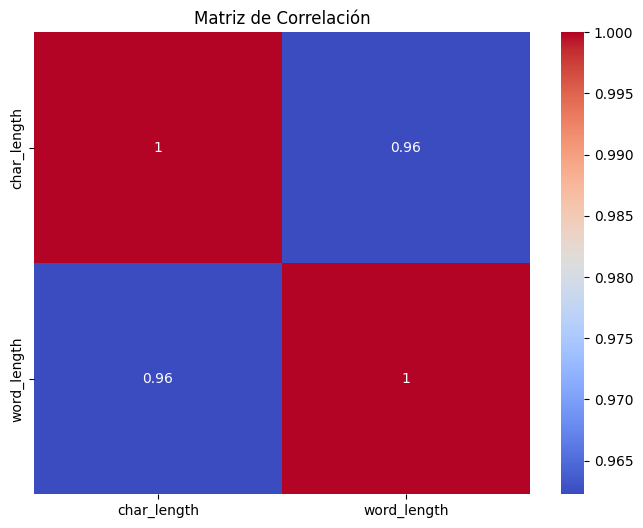

In [98]:
# matriz
correlation_matrix = df_preclean[['char_length', 'word_length']].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación')
plt.show()

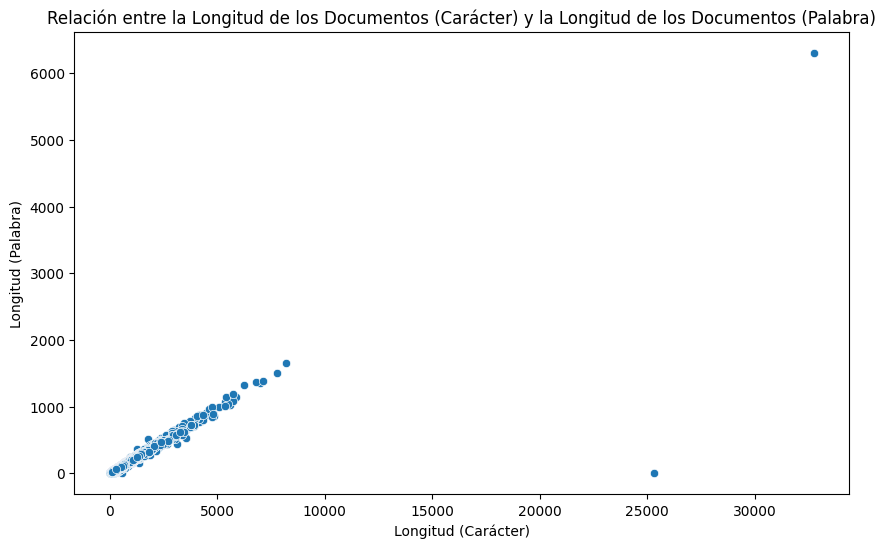

In [97]:
#ScatterPlot
plt.figure(figsize=(10, 6))
sns.scatterplot(x='char_length', y='word_length', data=df_preclean)
plt.title('Relación entre la Longitud de los Documentos (Carácter) y la Longitud de los Documentos (Palabra)')
plt.xlabel('Longitud (Carácter)')
plt.ylabel('Longitud (Palabra)')
plt.show()

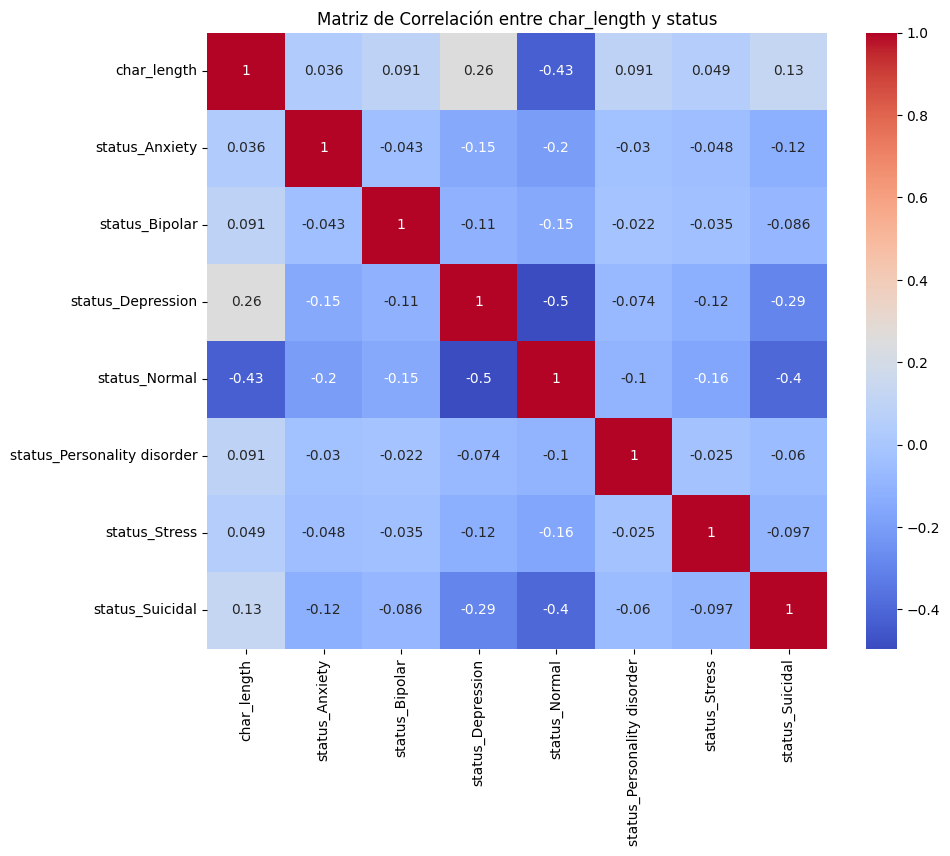

In [116]:
df_dummies = pd.get_dummies(df_preclean['status'], prefix='status')
# Concatenar las variables dummy con el DataFrame original
df_with_dummies_c = pd.concat([df_preclean[['char_length']], df_dummies], axis=1)
correlation_matrix = df_with_dummies_c.corr()
# matriz letras
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación entre char_length y status')
plt.show()

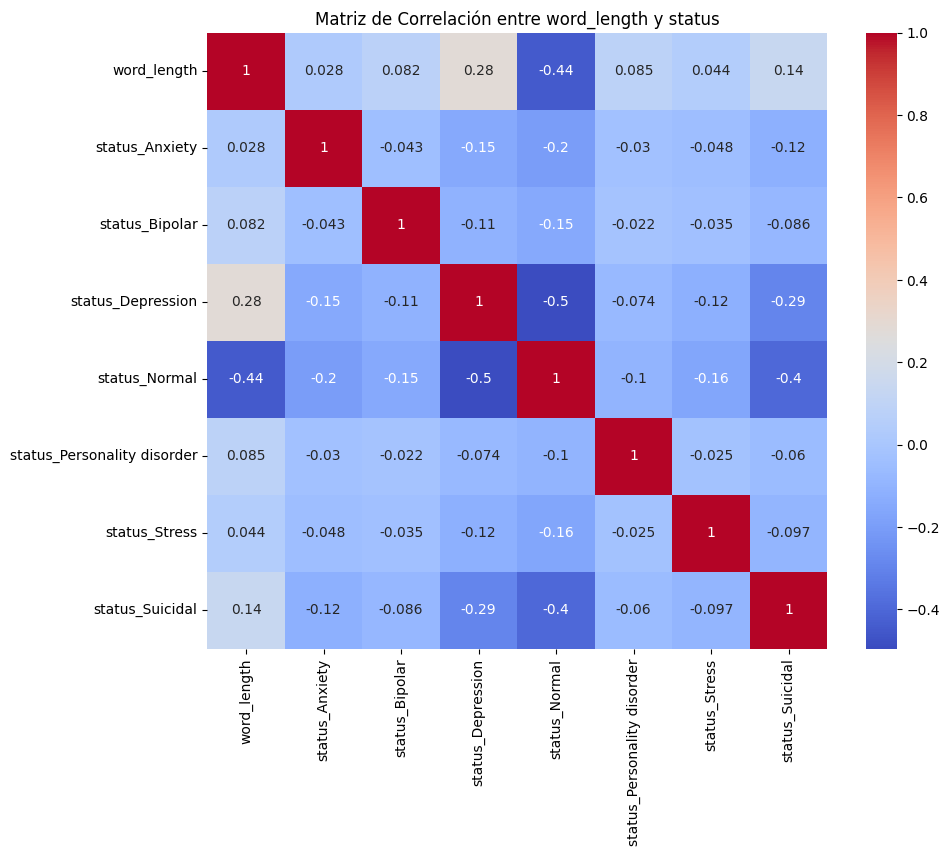

In [117]:
df_with_dummies_w = pd.concat([df_preclean[['word_length']], df_dummies], axis=1)
correlation_matrix = df_with_dummies_w.corr()
# matriz palabras
plt.figure(figsize=(10, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm')
plt.title('Matriz de Correlación entre word_length y status')
plt.show()

## **2. Limpieza de los Textos**
---

La selección de las técnicas de preprocesamiento del corpus puede variar en cada conjunto de datos. Recuerde que puede aplicar (no necesariamente todas) las técnicas generales vistas en el curso, tales como:

- Tokenizacion
- Normalización de textos.
- Limpieza con expresiones regulares.
- Lematización.
- Filtrado de palabras.
- Modificaciones en la grafía.

In [ ]:
%pip install textblob kagglehub emoji

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 590.6/590.6 kB 15.6 MB/s eta 0:00:00a 0:00:01
Note: you may need to restart the kernel to use updated packages.


In [ ]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import re
import string
import nltk
import emoji
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
import plotly.figure_factory as ff
from textblob import TextBlob
import numpy as np
from wordcloud import WordCloud
import matplotlib.pyplot as plt

In [ ]:
import kagglehub

# Download latest version
path = kagglehub.dataset_download("suchintikasarkar/sentiment-analysis-for-mental-health")

print("Path to dataset files:", path)

100%|██████████| 11.1M/11.1M [00:00<00:00, 19.2MB/s]

Extracting files...


Path to dataset files: /Users/diegof/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1


In [ ]:
# Load the data
path = '/Users/diegof/.cache/kagglehub/datasets/suchintikasarkar/sentiment-analysis-for-mental-health/versions/1/Combined Data.csv'
df = pd.read_csv(path)

In [ ]:
# Display the first few rows of the dataframe
print(df.head())

   Unnamed: 0                                          statement   status
0           0                                         oh my gosh  Anxiety
1           1  trouble sleeping, confused mind, restless hear...  Anxiety
2           2  All wrong, back off dear, forward doubt. Stay ...  Anxiety
3           3  I've shifted my focus to something else but I'...  Anxiety
4           4  I'm restless and restless, it's been a month n...  Anxiety


In [ ]:
print(df.columns)

Index(['Unnamed: 0', 'statement', 'status'], dtype='object')


La siguiente función de preprocesamiento está diseñada para limpiar y normalizar un texto antes de llevar a cabo análisis posteriores (como análisis de sentimientos). 

A continuación se detalla lo que hace cada parte del código:
1. Conversión a String: Se asegura que el input sea interpretado como una cadena de texto. Esto evita errores si se recibiera otro tipo de dato.
2.	Normalización (Minúsculas): Convierte todo el texto a minúsculas para eliminar distinciones entre mayúsculas y minúsculas, lo que facilita la comparación y el procesamiento posterior.
3.	Limpieza con Expresiones Regulares (Regex):
	* Eliminación de URLs: Se remueven secuencias que correspondan a direcciones web (http, https, www).
	* Eliminación de menciones y hashtags: Se eliminan tokens que comienzan con ‘@’ o ‘#’ (típicos en redes sociales).
	* Eliminación de caracteres especiales y números: Se filtran todos los caracteres que no son letras ni espacios, dejando solo el alfabeto.
4.	Tokenización: Utiliza word_tokenize de NLTK para dividir el texto en una lista de palabras o tokens, lo que permite tratar cada término de forma individual.
5.	Filtrado de Stopwords: Se utiliza el conjunto de palabras de poco valor semántico (stopwords) en inglés de NLTK para filtrar y eliminar palabras comunes (por ejemplo, “the”, “and”, “is”) que suelen aportar poco al análisis en términos de contenido informativo.
6.	Conversión de Emojis a Texto: Con demojize, cada token que contenga un emoji se reemplaza por su representación textual (por ejemplo, 😊 se convierte en :blush:). Esto permite capturar la información emocional de los emojis en forma de texto.
7.	Lematización: Se emplea WordNetLemmatizer para transformar cada token a su forma base o raíz (por ejemplo, “running” se convierte en “run”). Esto ayuda a reducir la variabilidad morfológica y mejora la consistencia en el análisis.
8.	Reconstrucción del Texto Limpio: Finalmente, se vuelven a unir los tokens procesados en una cadena de texto, obteniendo el texto final “limpio” y normalizado.

In [ ]:
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from emoji import demojize

# Descargar tokenizer y stopwords de NLTK
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

# Función para limpieza, normalización y tokenización
def limpiar_texto(texto):
    # Convertir a string por seguridad
    texto = str(texto)

    # 1. Normalización
    texto = texto.lower()

    # 2. Limpieza con Regex
    texto = re.sub(r'http\S+|www\S+|https\S+', '', texto)  # eliminar links
    texto = re.sub(r'@\w+|#\w+', '', texto)                # eliminar menciones y hashtags
    texto = re.sub(r'[^a-zA-Z\s]', '', texto)              # eliminar caracteres especiales y números

    # 3. Tokenización básica
    tokens = word_tokenize(texto)

    # 4. Filtrar stopwords (palabras comunes que no aportan información)
    stop_words = set(stopwords.words('english')) 
    tokens_filtrados = [token for token in tokens if token not in stop_words]

    # 5. Reemplazar emojis por su representación textual
    tokens_demojizados = [demojize(token) for token in tokens_filtrados]  

    # 6. Lematización (transformar palabras a su raíz)
    lemmatizer = WordNetLemmatizer()
    tokens_lemmatizados = [lemmatizer.lemmatize(token) for token in tokens_demojizados]
    
    # 7. Volver a unir tokens
    texto_limpio = ' '.join(tokens_lemmatizados)

    return texto_limpio

# Aplicar limpieza
df['clean_text'] = df['statement'].apply(limpiar_texto)

# Ver resultado
print(df[['statement', 'clean_text']].head())

[nltk_data] Downloading package punkt to /Users/diegof/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/diegof/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/diegof/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


                                           statement  \
0                                         oh my gosh   
1  trouble sleeping, confused mind, restless hear...   
2  All wrong, back off dear, forward doubt. Stay ...   
3  I've shifted my focus to something else but I'...   
4  I'm restless and restless, it's been a month n...   

                                          text_clean  
0                                            oh gosh  
1  trouble sleeping confused mind restless heart ...  
2  wrong back dear forward doubt stay restless re...  
3  ive shifted focus something else im still worried  
4                im restless restless month boy mean  


Por último se deja un ejemplo de cómo ha quedado un texto procesado con la función anterior:

In [ ]:
row = df[df['Unnamed: 0'] == 1]['statement']
clean_row = df[df['Unnamed: 0'] == 1]['clean_text']
print(row.values[0])
print(clean_row.values[0])

trouble sleeping, confused mind, restless heart. All out of tune
trouble sleeping confused mind restless heart tune


## **Créditos**

* **Profesor:** [Felipe Restrepo Calle](https://dis.unal.edu.co/~ferestrepoca/)
* **Asistentes docentes:**
    - [Juan Sebastián Lara Ramírez](https://www.linkedin.com/in/juan-sebastian-lara-ramirez-43570a214/).
* **Diseño de imágenes:**
    - [Rosa Alejandra Superlano Esquibel](mailto:rsuperlano@unal.edu.co).
* **Coordinador de virtualización:**
    - [Edder Hernández Forero](https://www.linkedin.com/in/edder-hernandez-forero-28aa8b207/).

**Universidad Nacional de Colombia** - *Facultad de Ingeniería*